# Predicción Abundancias Networld

---

## Setup

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from matplotlib.colors import Colormap

In [2]:
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional
from sklearn.metrics.pairwise import rbf_kernel

In [3]:
data_path = '../data/Networld_N200_TMax10000/'

In [4]:
betas = [0.001,0.0015849,0.0025119,0.0039811,0.0063096,
         0.01,0.015849,0.025119,0.039811,0.063096,
         0.1,0.15849,0.25119,0.39811,0.63096,
         1, 1.5849, 2.5119, 3.9811, 6.3096]

data = [pd.read_csv(data_path + f'ABD_MEA_N200_K5_Beta{beta}.csv') 
        for beta in betas]
data = pd.concat(data)

data['log(Size)'] = np.log10(data['Size'])
data['log(Ab)'] = np.log10(data['Ab'])
data['log(beta)'] = np.log10(data['beta'])

data.head()

,NRed,Ab,beta,Size,Lambda1,Lambda2,mu,Gr_Medio,H,log(Size),log(Ab),log(beta)
0,1,0.990503,0.001000,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,-0.004144,-3.000000
1,2,0.009488,0.001000,2,1.000000,1.0,2.0,1.000000,0.000000,0.301030,-2.022825,-3.000000
2,30,0.000009,0.001000,3,1.414214,0.0,1.0,1.333333,0.918296,0.477121,-5.068181,-3.000000
0,1,0.985471,0.001585,1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,-0.006356,-2.799998
1,2,0.014508,0.001585,2,1.000000,1.0,2.0,1.000000,0.000000,0.301030,-1.838395,-2.799998


Top 30 redes más pequeñas para gráficas donde no se pueden incluir todas las redes

In [5]:
small_nets = data[['NRed','Size']].drop_duplicates()
small_nets = small_nets.sort_values(by='Size', ascending=True)
small_nets = small_nets.head(10)['NRed']

small_nets = data.loc[data['NRed'].isin(small_nets)]

## Análisis exploratorio

### Distribuciones univariadas

***Variable Target***

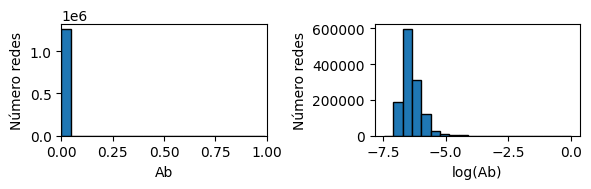

In [6]:
fig, axs = plt.subplots(1,2, figsize=(6,2))

data['Ab'].plot.hist(bins=20, edgecolor='black', ax=axs[0])
axs[0].set_xlim([0,1])
axs[0].set_xlabel('Ab')
axs[0].set_ylabel('Número redes')

data['log(Ab)'].plot.hist(bins=20, edgecolor='black', ax=axs[1])
axs[1].set_xlabel('log(Ab)')
axs[1].set_ylabel('Número redes')

fig.tight_layout()

Las abundancias claramente se deberán tratar en términos logarítmicos (o de forma similar como en una función logística) porque en términos absolutos habría un desequilibrio masivo de los datos.

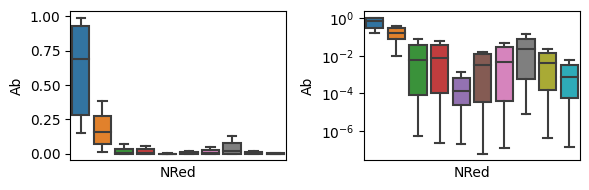

In [11]:
fig, axs = plt.subplots(1,2, figsize=(6,2))
sn.boxplot(data=small_nets, y='Ab', x='NRed', ax=axs[0])
axs[0].set_xlabel('NRed')
axs[0].set_xticks([])

sn.boxplot(data=small_nets, y='Ab', x='NRed', ax=axs[1])
axs[1].set_xlabel('NRed')
axs[1].set_yscale('log')
axs[1].set_xticks([])

fig.tight_layout()

Esta gráfica demuestra que es necesario contar con $\beta$ para predecir las abundancias, ya que de lo contrario los rangos de variación son descomunales.

***Variables predictoras***

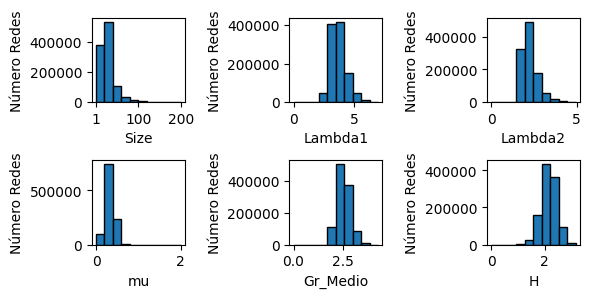

In [5]:
measures = data[['NRed','Size','Lambda1','Lambda2','mu','Gr_Medio','H']].drop_duplicates(subset='NRed')
xticks = [[1,100,200],
          None,None,None,None,None]

fig, axs = plt.subplots(2,3,figsize=(6,3))
axlist = [ax for axl in axs for ax in axl]
for i,col in enumerate(measures.columns[1:]):
    measures[col].plot.hist(ax=axlist[i], edgecolor='black')
    axlist[i].set_xlabel(col)
    if xticks[i] is not None:
        axlist[i].set_xticks(xticks[i])
    axlist[i].set_ylabel('Número Redes')

fig.tight_layout()

Algunas variables parecen ser aproximadamente normales, y otras parecen seguir una gamma.

El número de redes de cierto tamaño crece siempre de acuerdo a una "exponencial?". El decrecimiento en el número observado se debe a que el sistema no tiene tiempo / oportunidad para formarlas todas

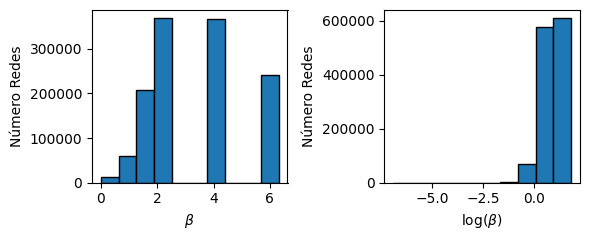

In [32]:
fig, axs = plt.subplots(1,2,figsize=(6,2.5))
data['beta'].plot.hist(ax=axs[0], edgecolor='black')
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel('Número Redes')
data['log(beta)'].plot.hist(ax=axs[1], edgecolor='black')
axs[1].set_xlabel(r'log($\beta$)')
axs[1].set_ylabel('Número Redes')

fig.tight_layout()

Equivalente al número de configuraciones en función de $\beta$ (aquí se ve peor). En cualquier caso muestra como hay más redes con abundancia para betas altas (irrelevante ya que se incluirán posteriormente todas las redes en todas las betas).

### Distribuciones bivariadas

***Variable predictora - target***

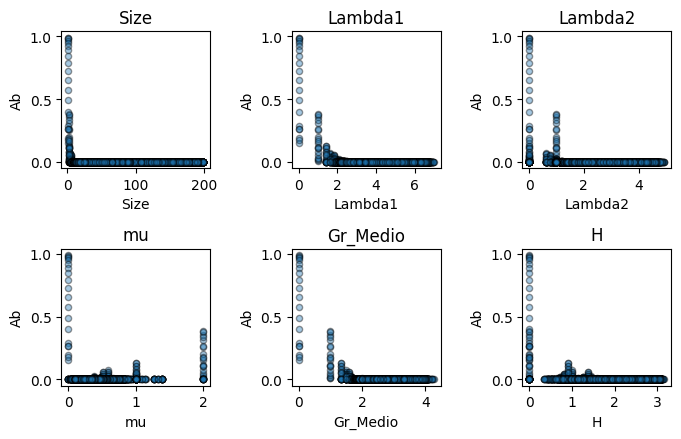

In [33]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

meas_columns = ['Size','Lambda1','Lambda2','mu','Gr_Medio','H']
for i, col in enumerate(meas_columns):
    data.plot.scatter(x=col, y='Ab', alpha=0.4, edgecolor='black', ax=axlist[i])
    axlist[i].set_title(col)
    axlist[i].locator_params(axis='x', nbins=4)
fig.tight_layout()

Las variables predictoras no parecen muy informativas sobre la abundancia lineal

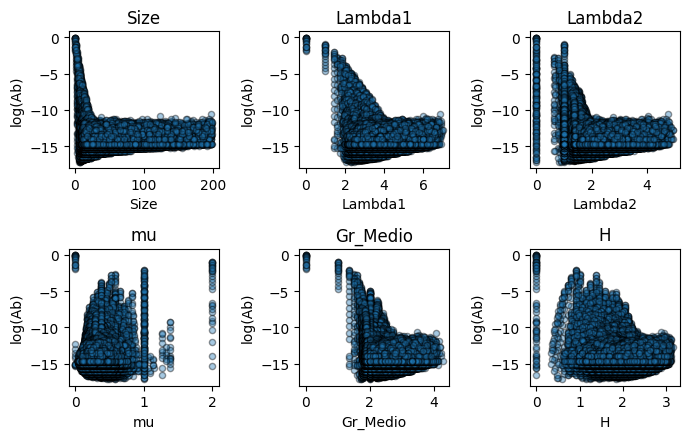

In [34]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

meas_columns = ['Size','Lambda1','Lambda2','mu','Gr_Medio','H']
for i, col in enumerate(meas_columns):
    data.plot.scatter(x=col, y='log(Ab)', alpha=0.4, edgecolor='black', ax=axlist[i])
    axlist[i].set_title(col)
    axlist[i].locator_params(axis='x', nbins=4)
fig.tight_layout()

Sobre la abundancia logarítmica se aprecia algo más de información. Algunas medidas como Size, Lambdas o GrMedio tienen abundancias muy bajas para sus valores extremos (pero este comportamiento en general debería desaparecer con $\beta$ mayor).

En cualquier caso parece claro que en ausencia de una $\beta$ no hay correlaciones apreciables. 

Aun así se repite la figura del tamaño con límite a ~20 para comprobar el comportamiento con las redes más pequeñas

(0.0, 20.0)

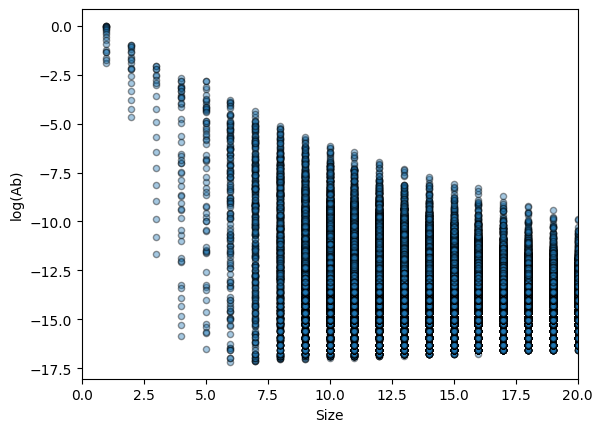

In [36]:
data.plot.scatter(x='Size', y='log(Ab)', alpha=0.4, edgecolor='black')
plt.xlim(0,20)

En estos límites se aprecia que cuando las redes son pequeñas si existe una cierta correlación, pero se va perdiendo cuando aumenta el tamaño de las redes (y en cualquier caso una mejor correlación requeriría una $\beta$ fija).

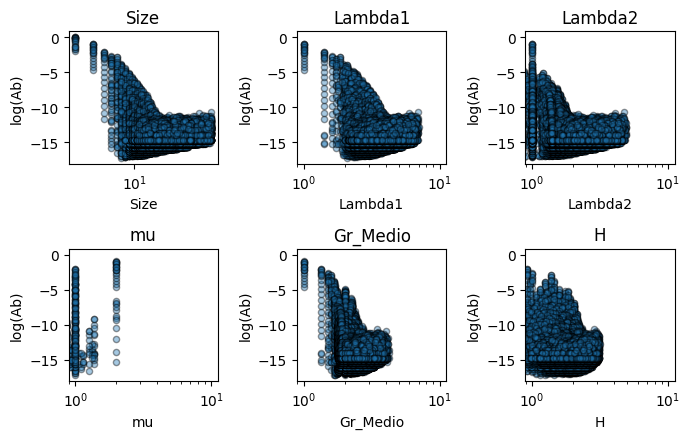

In [37]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

meas_columns = ['Size','Lambda1','Lambda2','mu','Gr_Medio','H']
for i, col in enumerate(meas_columns):
    data.plot.scatter(x=col, y='log(Ab)', alpha=0.4, edgecolor='black', ax=axlist[i])
    axlist[i].set_title(col)
    axlist[i].locator_params(axis='x', nbins=4)
    axlist[i].set_xscale('log')
fig.tight_layout()

La escala logarítmica aclara un poco la cosa y sugiere un poco mejor la correlación por lo menos con Size, pero sigue sin ser algo de donde se pueda sacar nada.

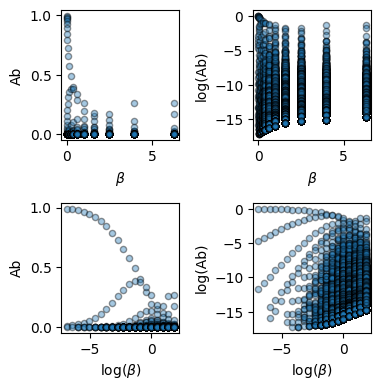

In [38]:
fig, axs = plt.subplots(2,2,figsize=(4,4))

data.plot.scatter(x='beta', y='Ab', alpha=0.4, edgecolor='black', ax=axs[0][0])
axs[0][0].set_xlabel(r'$\beta$')
data.plot.scatter(x='beta', y='log(Ab)', alpha=0.4, edgecolor='black', ax=axs[0][1])
axs[0][1].set_xlabel(r'$\beta$')
data.plot.scatter(x='log(beta)', y='Ab', alpha=0.4, edgecolor='black', ax=axs[1][0])
axs[1][0].set_xlabel(r'log($\beta$)')
data.plot.scatter(x='log(beta)', y='log(Ab)', alpha=0.4, edgecolor='black', ax=axs[1][1])
axs[1][1].set_xlabel(r'log($\beta$)')

fig.tight_layout()

Obviamente, $\beta$ por si sola tampoco determina la abundancia en ninguna escala. Para cualquier beta hay una gran diversidad de abundancias.

***Figura 3A - PNAS***

Text(0.5, 0, '$\\beta$')

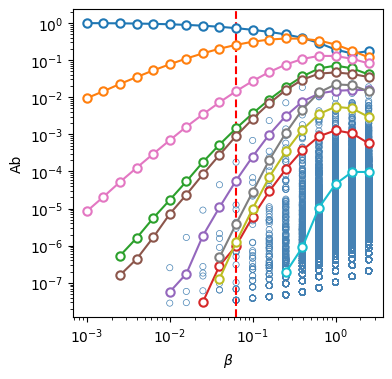

In [7]:
fig, ax = plt.subplots(figsize=(4,4))
ax.axvline(x=10**(-1.2), ls='--', color='red')
data.plot.scatter(x='beta', y='Ab', ax=ax, edgecolor='steelblue', c='none', linewidths=0.5)
pivot_data = pd.pivot_table(data=small_nets, index='beta', columns='NRed', values='Ab')
pivot_data.plot(style='-o',markerfacecolor='white', markeredgewidth=1.5, legend=False, ax=ax)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\beta$')

***Figura 3C - PNAS***

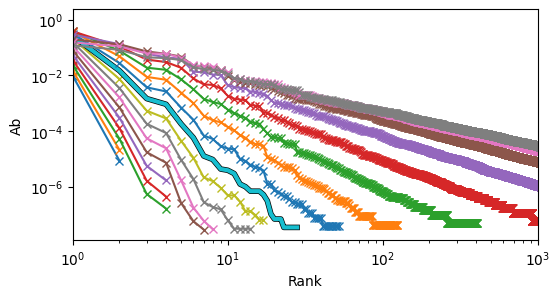

In [9]:
fig, ax = plt.subplots(figsize=(6,3))
for beta in betas:
    beta_ab = data.loc[data['beta'] == beta]
    beta_ab = beta_ab.sort_values(by='Ab', ascending=False)
    if beta == 0.063096:
        ax.plot(beta_ab['Ab'].values, '-', linewidth=4, color='black')
        ax.plot(beta_ab['Ab'].values, '-', linewidth=3)
    else:
        ax.plot(beta_ab['Ab'].values, '-x')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1,1000)
    plt.xlabel('Rank')
    plt.ylabel('Ab')

***Variables predictoras - predictoras***

In [9]:
measure_table = measures[meas_columns].reset_index(drop=True)

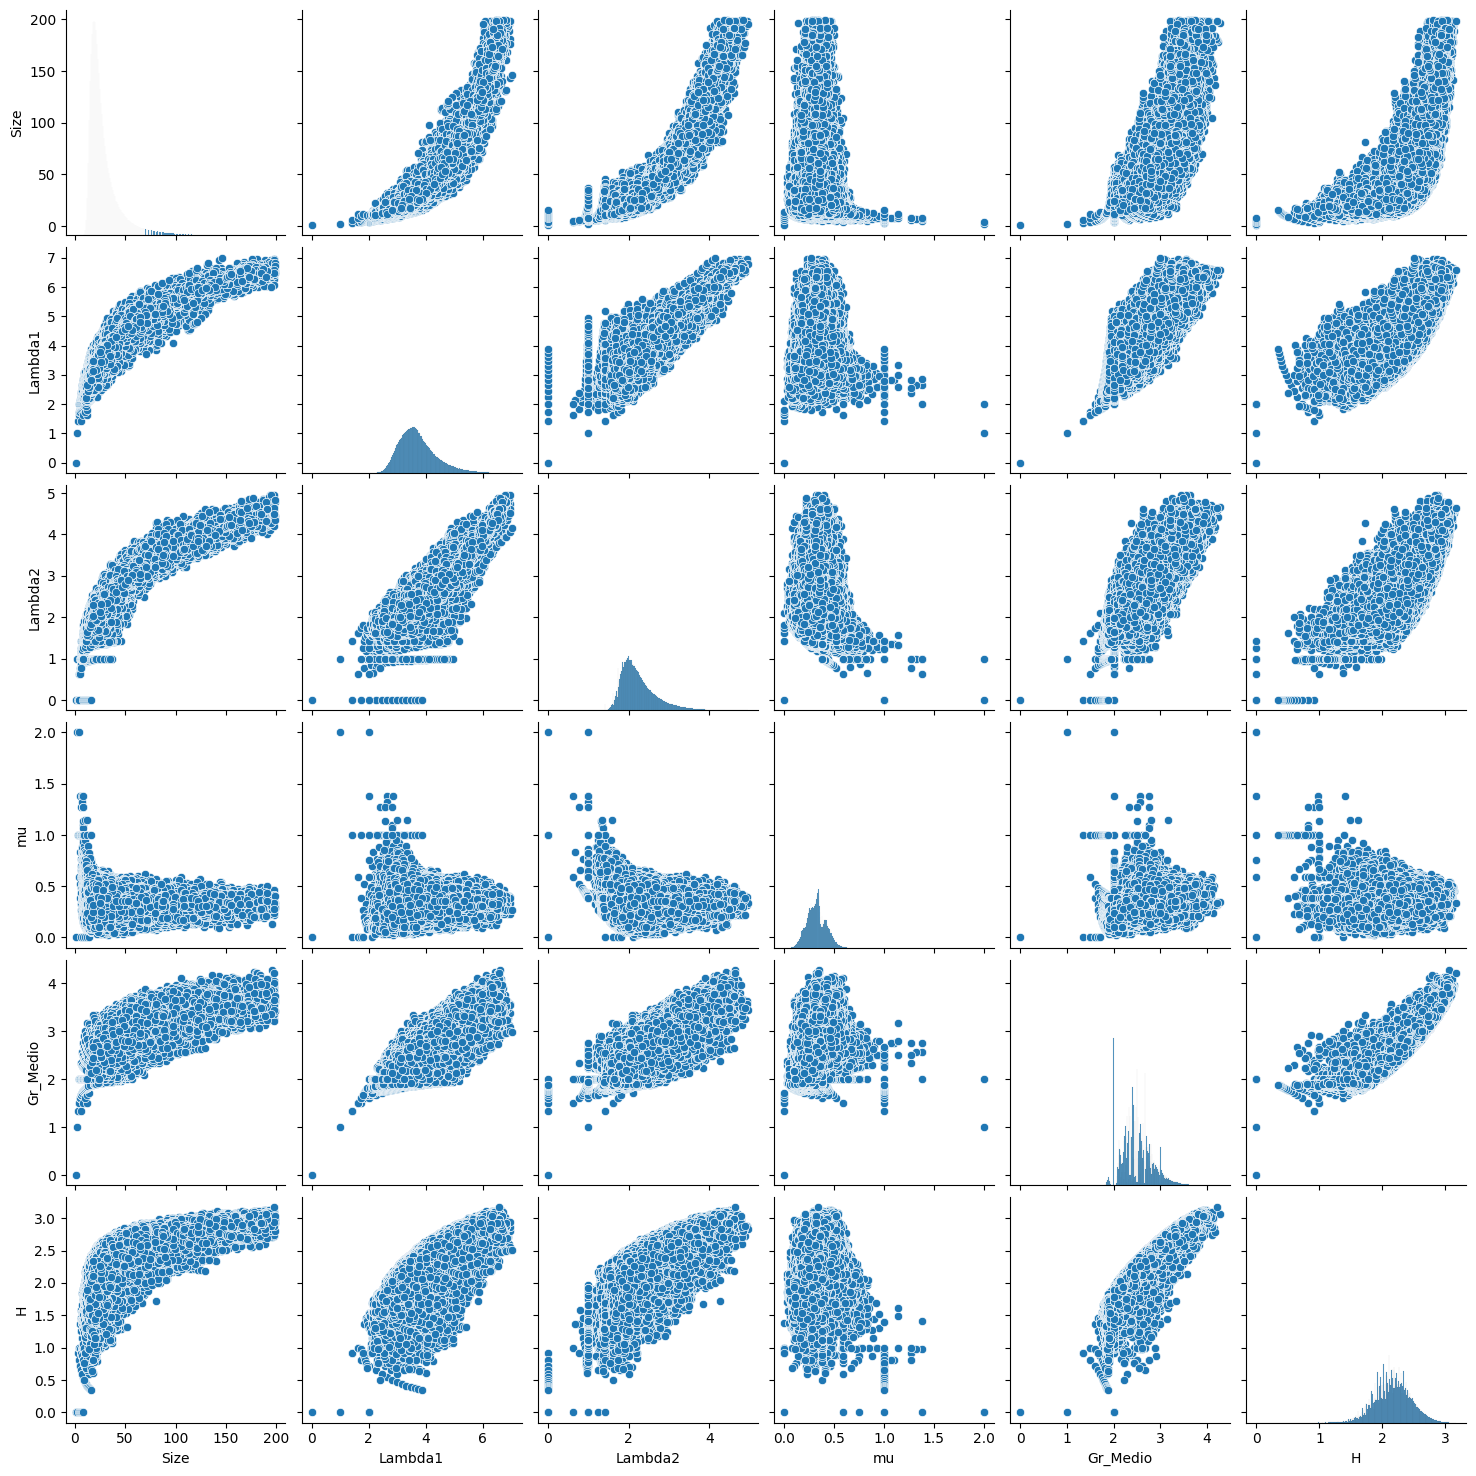

In [47]:
sn.pairplot(measure_table)

Se encuentran en general correlaciones importantes entre las variables (Lambda1 y La,bda2, Lambda1 y H, Gr_Medio y H). Esta información se resume mejor mediante la matriz de correlación.

De todas formas algunas correlaciones parecen tener un carácter logarítmico (Size con algunas de las anteriores).

Mu es la única medida que no está correlacionada con las demás.

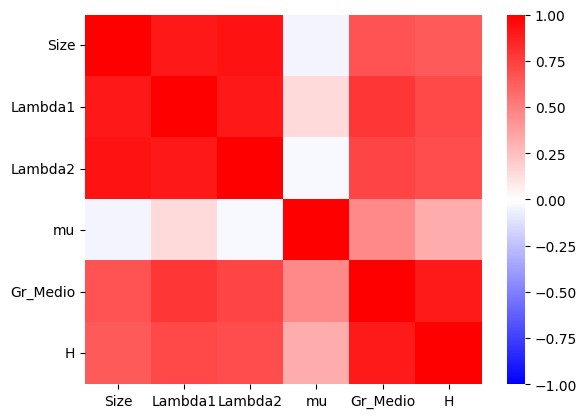

In [52]:
sn.heatmap(measure_table.corr(), cmap='bwr', vmin=-1,vmax=1)

Confirmamos las altísimas correlaciones entre variables (incluso si la relación real en algunos casos tiene carácter logarítmico) y que la única variable que es algo independiente es $\mu$.

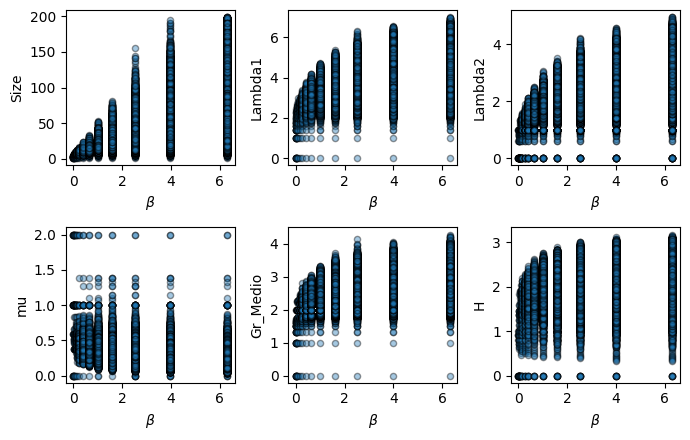

In [10]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

for i,col in enumerate(meas_columns):
    data.plot.scatter(x='beta', y=col, ax=axlist[i], alpha=0.4, edgecolor='black')
    axlist[i].set_xlabel(r'$\beta$')

fig.tight_layout()

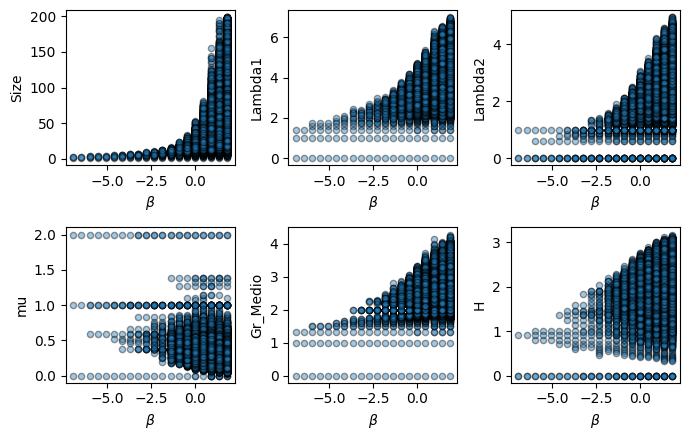

In [11]:
fig, axs = plt.subplots(2,3,figsize=(7,4.5))
axlist = [ax for axl in axs for ax in axl]

for i,col in enumerate(meas_columns):
    data.plot.scatter(x='log(beta)', y=col, ax=axlist[i], alpha=0.4, edgecolor='black')
    axlist[i].set_xlabel(r'$\beta$')

fig.tight_layout()

De nuevo ocurre que aunque no hay correlaciones en sentido estricto, si comprobamos que con $\beta$ mas altos aparecen redes más grandes, y en general mayores valores para varias medidas.

Cuando se incluyan todas las redes para todas las $\beta$ desaparecerá este efecto, pero de momento se puede usar como proxy para las abundancias de las redes en función de ambos parámetros de forma simultánea.

### Predictibilidad conjunta

En base a los resultados anteriores se puede intuir que habrá muy poca predictibilidad incluso al considerar $\beta$ si se la maneja como una variable más sin una consideración especial.

Dicho eso, parece apropiado al menos comprobar utilizando la siguiente combinación de varialbles:

$Ab = f(Size, \mu, \beta)$

Además, antes de intentar estimar la predictibilidad con una combinación de 3 parámetros (algo complicado), se intentará a hacerlo con los pares de Size + $\beta$ y $\mu$ + $\beta$

***Distribución Size + $\beta$***


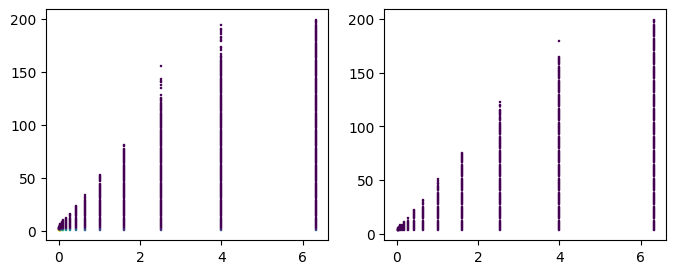

In [53]:
mean_ab = data.groupby(['Size','beta'])['Ab'].mean().reset_index()
std_ab = data.groupby(['Size','beta'])['Ab'].std().reset_index()

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(x=mean_ab['beta'], y=mean_ab['Size'], c=mean_ab['Ab'], s=0.5, marker='s', vmin=0, vmax=1)
axs[1].scatter(x=std_ab['beta'], y=std_ab['Size'], c=std_ab['Ab'], s=0.5, marker='s', vmin=0, vmax=1)


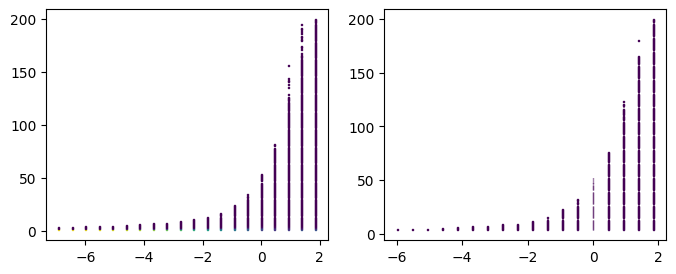

In [54]:
mean_ab = data.groupby(['Size','log(beta)'])['Ab'].mean().reset_index()
std_ab = data.groupby(['Size','log(beta)'])['Ab'].std().reset_index()

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(x=mean_ab['log(beta)'], y=mean_ab['Size'], c=mean_ab['Ab'], s=0.5, marker='s', vmin=0, vmax=1)
axs[1].scatter(x=std_ab['log(beta)'], y=std_ab['Size'], c=std_ab['Ab'], s=0.5, marker='s', vmin=0, vmax=1)

Text(0.5, 0, '$\\beta$')

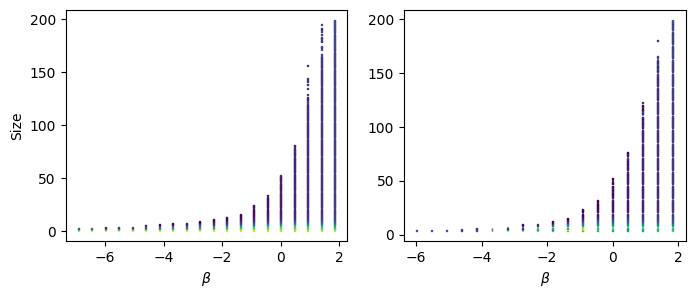

In [58]:
mean_ab = data.groupby(['Size','log(beta)'])['log(Ab)'].mean().reset_index()
std_ab = data.groupby(['Size','log(beta)'])['log(Ab)'].std().reset_index()

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(x=mean_ab['log(beta)'], y=mean_ab['Size'], c=mean_ab['log(Ab)'], s=0.5, marker='s')
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel('Size')
axs[1].scatter(x=std_ab['log(beta)'], y=std_ab['Size'], c=std_ab['log(Ab)'], s=0.5, marker='s')
axs[1].set_xlabel(r'$\beta$')

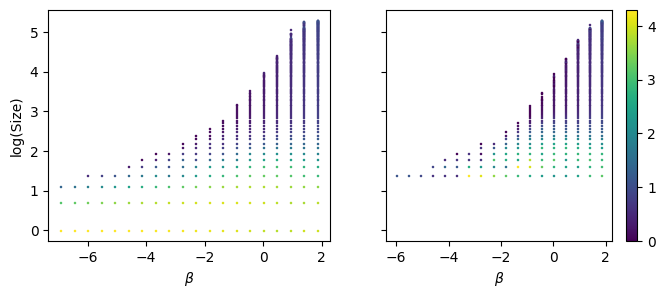

In [62]:
data['log(Size)'] = np.log(data['Size'])

mean_ab = data.groupby(['log(Size)','log(beta)'])['log(Ab)'].mean().reset_index()
std_ab = data.groupby(['log(Size)','log(beta)'])['log(Ab)'].std().reset_index()

fig, axs = plt.subplots(1,2,figsize=(8,3), sharey=True)
axs[0].scatter(x=mean_ab['log(beta)'], y=mean_ab['log(Size)'], c=mean_ab['log(Ab)'], s=0.5, marker='s')
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel('log(Size)')
im = axs[1].scatter(x=std_ab['log(beta)'], y=std_ab['log(Size)'], c=std_ab['log(Ab)'], s=0.5, marker='s')
axs[1].set_xlabel(r'$\beta$')

fig.colorbar(im)

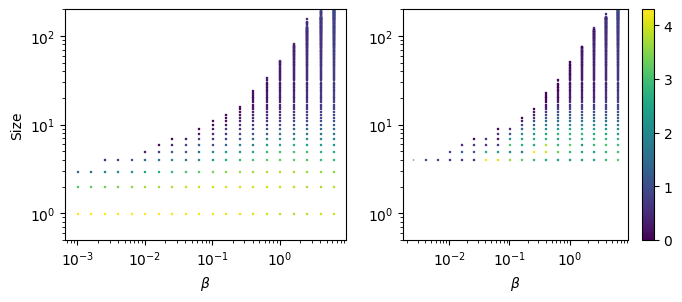

In [74]:
mean_ab = data.groupby(['Size','beta'])['log(Ab)'].mean().reset_index()
std_ab = data.groupby(['Size','beta'])['log(Ab)'].std().reset_index()

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(x=mean_ab['beta'], y=mean_ab['Size'], c=mean_ab['log(Ab)'], s=0.5, marker='s')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel('Size')
axs[0].set_ylim(0.5,200)
im = axs[1].scatter(x=std_ab['beta'], y=std_ab['Size'], c=std_ab['log(Ab)'], s=0.5, marker='s')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\beta$')
axs[1].set_ylim(0.5,200)
fig.colorbar(im)

Esta figura es una de las mejores aproximaciones (que he conseguido obtener) a la predictibilidad de la abundancia según el tamaño y la $\beta$. 

Comprobamos que las redes más grandes para una cierta $\beta$ tienden a tener abundancias relativamente consistentes (desviaciones de <1 en logaritmo), pero hay una región muy amplia donde la dispersión es muy grande y hay poca predictibilidad.

Para varios $\beta$, redes con el mismo tamaño tienen abundancias muy diferentes.

***Distribución $\mu$ + $\beta$***

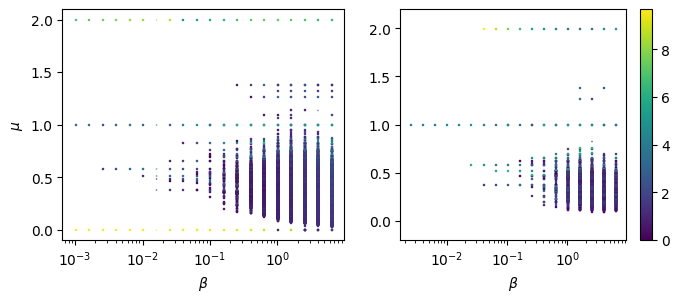

In [78]:
mean_ab = data.groupby(['mu','beta'])['log(Ab)'].mean().reset_index()
std_ab = data.groupby(['mu','beta'])['log(Ab)'].std().reset_index()

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(x=mean_ab['beta'], y=mean_ab['mu'], c=mean_ab['log(Ab)'], s=0.5, marker='s')
axs[0].set_xscale('log')
#axs[0].set_yscale('log')
axs[0].set_xlabel(r'$\beta$')
axs[0].set_ylabel(r'$\mu$')
axs[1].set_ylim(-0.2,2.2)
im = axs[1].scatter(x=std_ab['beta'], y=std_ab['mu'], c=std_ab['log(Ab)'], s=0.5, marker='s')
axs[1].set_xscale('log')
#axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\beta$')
axs[1].set_ylim(-0.2,2.2)
fig.colorbar(im)

El caso de $\mu$ es un poco más sútil. 

Por un lado, la escala de la desviación es mucho mayor, por lo que las abundancias están menos determinadas en general. Sin embargo, hay toda una región de redes cuya abundancia no es excesivamente variable.

Además tenemos 3 bandas de valores privilegiados (mu=0,1,2). Mu=0 esta reservado para la red de un nodo por lo que nunca tiene dispersión, Mu=1 corresponde a alguna red pequeña pero también tiene otras pequeñas, y Mu=2 corresponde a una red pequeña pero también a otras más grandes que aparecen para $\beta$ alto.

***Distribucion Size + $\mu$ + $\beta$***

Text(0, 0.5, 'Number of Size + $\\mu$ + $\\beta$ bins')

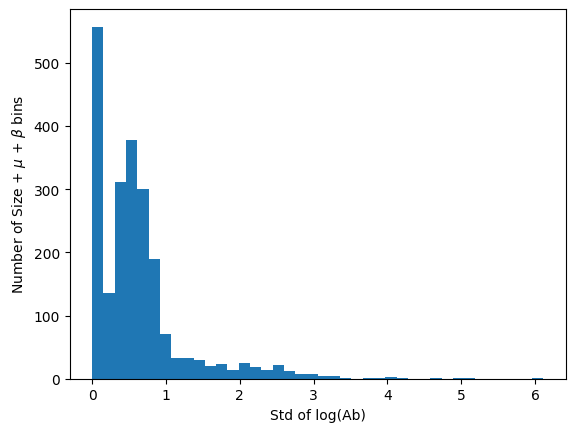

In [96]:
data['mu_disc'] = pd.cut(data['mu'], 10, labels=False)

std_ab = data.groupby(['Size','mu_disc','beta'])['log(Ab)'].std().reset_index().fillna(0)
#std_ab = std_ab.loc[std_ab['log(Ab)']<=1]
plt.hist(std_ab['log(Ab)'], bins=40)
plt.xlabel('Std of log(Ab)')
plt.ylabel(r'Number of Size + $\mu$ + $\beta$ bins')

Aunque es muy dificil interpretar estos gráficos correctamente, a priori sugiere que combinando ambas medidas se mejora en cierto grado la predicción de abundancia, ya que la mayoría de desviaciones están al menos por debajo de 1.

De todas formas sigue sin ser nada del otro mundo...

***Error predicción***

Utilizando las 3 variables como predictoras

In [5]:
X = data[['log(Size)','mu','log(beta)']]
X.head()

,log(Size),mu,log(beta)
0,0.000000,0.0,-3.000000
1,0.301030,2.0,-3.000000
2,0.477121,1.0,-3.000000
0,0.000000,0.0,-2.799998
1,0.301030,2.0,-2.799998


In [6]:
y = data['log(Ab)']
y.head()

0   -0.004144
1   -2.022825
2   -5.068181
0   -0.006356
1   -1.838395
Name: log(Ab), dtype: float64

In [7]:
index = X.notna().all(axis=1)
X = X.loc[index]
y = y.loc[index]

In [8]:
train = np.random.choice(range(len(X)), size=500000)
Xtrain = X.iloc[train]
ytrain = y.iloc[train]

In [9]:
test = np.random.choice(range(len(X)), size=1000)
Xtest = X.iloc[test]
ytest = y.iloc[test]

In [24]:
ypreds = []

for i in range(len(Xtest)):
    Xdata = Xtest.iloc[i:i+1]
    kernel = rbf_kernel(Xdata, Xtrain)[0]
    norm = kernel.sum()
    ypred = (kernel*ytrain).sum() / norm
    ypreds.append(ypred)

ypreds = np.array(ypreds)

In [19]:
ypreds

array([-1.36530948e-05, -1.28612688e-05, -1.33408739e-05, ...,
       -1.36309427e-05, -1.37347385e-05, -1.17703403e-05])

In [140]:
i=0
Xdata = Xtest.iloc[i:i+1]
kern = rbf_kernel(Xdata, X)

for col in meas_col

## 